# Getting Started

In [4]:
import pandas as pd

token_path = "C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flickr8k_text\\Flickr8k.token.txt"
#We save the path to the file in a variable.

data = []
with open(token_path, 'r') as file:
    for line in file:
        tokens = line.split()
        image_filename = tokens[0].split('#')[0]
        caption = ' '.join(tokens[1:])
        data.append((image_filename, caption))

#Ideally, each line in the file looks like this - 1000268201_693b08cb0e.jpg#0 A child in a pink dress is climbing up a set of stairs in an entry way.
#First we split it into tokens. For example, the line "1000268201_693b08cb0e.jpg#0 A child in a pink dress." would be split into tokens: ["1000268201_693b08cb0e.jpg#0", "A", "child", "in", "a", "pink", "dress."].
#tokens[0] gets the first token from the list, which looks like "1000268201_693b08cb0e.jpg#0".
#.split('#') splits this token into two parts based on the # character: ["1000268201_693b08cb0e.jpg", "0"].
#[0] then selects the first part, which is the filename of the image: "1000268201_693b08cb0e.jpg".
#".join(tokens[1:])" takes all the tokens from the second token to the end and  joins these tokens back together into a single string, with spaces between each token.
#Finbally, we form a tuple containing the image filename and its corresponding caption to the data list.        

df = pd.DataFrame(data, columns=['image_filename', 'caption'])
# We convert the list into a DataFrame


df.head()

image_filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
df.shape

(40460, 2)

In [6]:
# Extract all image filenames from the data list
image_filenames = [item[0] for item in data]

# Convert the list of filenames into a set to remove duplicates
distinct_filenames = set(image_filenames)

# Print the number of distinct filenames
print(len(distinct_filenames))

#Hence we are using 8092 distinct images.

8092


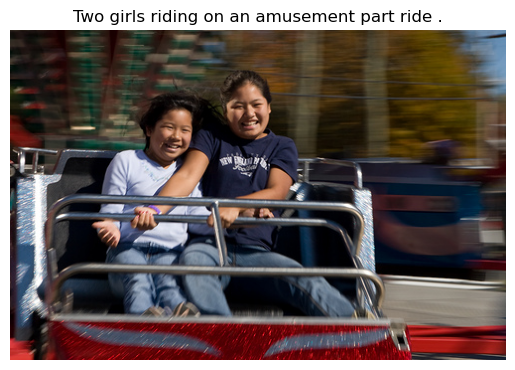

In [7]:
#Now we will try to display an image with associated caption

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample_row = df.sample(1).iloc[0]
#The sample method on a DataFrame randomly selects a specified number of rows. 
#We use iloc[0] to select the first row of the data frame that is provided by the sample. 
#Even though we put '1' as the argument in sample, it still creates a dataframe out of it.
img = mpimg.imread('C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flicker8k_Images\\' + sample_row['image_filename'])
#mpimg.imread is a function that reads an image from a file. 
plt.imshow(img)
plt.title(sample_row['caption'])
plt.axis('off')
plt.show()


# Feature Extraction of Images

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# VGG16 is a pre-trained deep learning model known for achieving top accuracy in the ImageNet Large Scale Visual Recognition Challenge.
# preprocess_input: It's a function that carries out the specific preprocessing steps required for images before they can be inputted to a VGG16 model. This includes tasks like pixel normalization and scaling.
from tensorflow.keras.models import Model
# "Model" is a class that allows VGG16 to add more layers and hence improve its functionality
from tensorflow.keras.preprocessing import image
# This module provides utilities and functions to preprocess images and prepare them for use with neural networks or other machine learning models.
import numpy as np

base_model = VGG16(weights='imagenet')
#This line instantiates the VGG16 model with weights pre-trained on the ImageNet dataset. 
#The weights='imagenet' argument means that the model will be loaded with weights trained on the ImageNet dataset, a very large dataset with over a million labeled images spanning 1000 categories.


model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)  
# The line is creating a new model (model) that uses the same input as the base_model, but its output is the output of a specific layer ('fc2') from the base_model.
# The ability to extract the output from a particular layer in a pre-existing model is provided by the Model class in Keras.
# The 'fc2' layer is the second-to-last layer in the VGG16 model and outputs a 4096-dimensional vector.
# Using this layer (instead of the final layer) means we're getting a rich representation of the image without the final classification step, which is ideal for our retrieval task.
# Basically, we get a feature vector that encapsulates the content of the image but isn't tied to any specific classification. 

In [9]:
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # VGG16 expects images of size 224x224. This line is basically resizing the images.
    img_array = image.img_to_array(img) #Line 2
    expanded_img_array = np.expand_dims(img_array, axis=0) #Line 3
    preprocessed_img = preprocess_input(expanded_img_array)  #Line 4
    features = model.predict(preprocessed_img) #Line 5
    flattened_features = features.flatten() #Line 6
    normalized_features = flattened_features / np.linalg.norm(flattened_features)  #Line 7 -  Normalize the features
    return normalized_features #Line 8

#Explaining the function -
# When you use the image.load_img function from the TensorFlow Keras image module to load and resize an image, it internally converts the image to the PIL (Python Imaging Library) format.
#Line 2 - Converts the loaded image (which is in PIL format) into a numpy array, so we can further process it. Numpy format is more compatible with the libraries inside python and most models that are used for training take numpy arrays as input.
#Line 3 - Neural network models often expect a batch of images as input, even if you're only using a single image.
#         "np.expand_dims(img_array, axis=0)" adds a new dimension at the beginning of the array, effectively transforming it from a 3D array into a 4D array. 
#         The resulting "expanded_img_array" is now a 4D NumPy array with dimensions (1, height, width, channels), representing a single image in a batch.
#Line 4 - Preprocessing the input data.
#Line 5 - Predict in this case is being used differently because we arent asking the model to predict the result of a test data. We are just using it to generate features that will be further used in our project.
#         "features" typically refer to the patterns, representations, or characteristics extracted from the input data. 
#Line 6 - After Line 5, the variable features contains the features extracted from the neural network model. These features are typically represented as a multi-dimensional tensor, where each dimension corresponds to different aspects or channels of the features.
#         The features.flatten() function takes this multi-dimensional tensor and reshapes it into a one-dimensional array. It essentially "flattens" the data by arranging all the values in a linear sequence.
#Line 7 - Basically after we have flattened the multidimensional array of "features", we do this step to ensure that each feature has similar importance.

In [15]:
#We now modify the above function so that it can handle a batch of images instead of just one eevry time.
def extract_features_batch(img_paths, model):
    # List to hold preprocessed images
    img_list = []

    # Process each image path
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        img_list.append(preprocessed_img)

    # Convert list of arrays into a single array
    batch_data = np.vstack(img_list)
    
    # Extract features for the entire batch
    batch_features = model.predict(batch_data)

    # Normalize and return the features
    normalized_features = []
    for features in batch_features:
        flattened_features = features.flatten()
        normalized_feature = flattened_features / np.linalg.norm(flattened_features)
        normalized_features.append(normalized_feature)

    return normalized_features


In [16]:
import os

# Specify the directory where the images are located
image_directory = 'C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flicker8k_Images\\'  # Replace 'path_to_directory' with the actual path to your images

# Get a list of all filenames in that directory
all_image_filenames = [f for f in os.listdir(image_directory) if f.endswith('.jpg')]

In [19]:
batch_size = 1000

num_batches = len(all_image_filenames) // batch_size + 1 
# We find the total number of batches required and then add one in case there are remaining images that dont form a batch.
batches = [all_image_filenames[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]
# the line creates a list of batches, where each batch is a sublist of image filenames from all_image_filenames, and each batch contains a specified number of images determined by the batch_size. 
image_features = {}

for batch in batches:
    # Create batch of image paths
    img_paths = [image_directory + img_filename for img_filename in batch]
    #We basically create a sublist of image file paths for each batch. 
    batch_features = extract_features_batch(img_paths, model)
    
    for img_filename, features in zip(batch, batch_features):
        image_features[img_filename] = features
    #Stores the extracted features for each image in the image_features dictionary, using the image filename as the key.

3/3 [==============================] - 17s 4s/step


In [20]:
import pickle

with open('image_features.pkl', 'wb') as file:
    pickle.dump(image_features, file)
#We copied the dictionary to a .pkl file that we created in write mode. And .pkl means its a 'pickle'  module file. Pickle module provides functions for serializing and deserializing Python objects.

# Text Processing

In [23]:
from gensim.parsing.preprocessing import remove_stopwords

# Apply the remove_stopwords function to the 'caption' column
df['processed_caption'] = df['caption'].apply(remove_stopwords)


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most frequent words
tfidf_matrix = vectorizer.fit_transform(df['processed_caption'])
#TF-IDF Vectorizer: This specific vectorizer transforms text into vectors where each word's value is weighted by its frequency in a document relative to its frequency across all documents.
# The above matrix can be used later for comparing against queries

# Building the Retrieval System

In [43]:
def retrieve_imagezz(query):
    # Convert the query to the same vector space as our captions
    query_vec = vectorizer.transform([query])
    #we vectorise the query that was enteres as input so we can match it to a value from df['processed_caption']
    cosine_similarities = cosine_similarity(query_vec, tfidf_matrix)
    #cosine_similarity is a function often provided by machine learning libraries (e.g., scikit-learn) to compute the cosine similarity between two vectors.
    #The resulting cosine_similarities is an array of cosine similarity scores, where each score indicates the similarity between the query and a caption.
    
    top_indices = cosine_similarities.argsort().flatten()[-5:]
    # Sort the array "cosine_similarities", flatten it to one dimension, get the indices of the 5 most similar captions
    
    retrieved_images = df.iloc[top_indices]
    # It selects the rows from the DataFrame df based on the indices obtained earlier (top_indices), representing the retrieved images.
    
    return retrieved_images

In [44]:
import pickle

with open('image_features.pkl', 'rb') as f:
    image_features = pickle.load(f)

#Load the image_features.pkl into memory which will give you a dictionary where keys are image filenames and values are the corresponding feature vectors.

In [45]:
def preprocess_text(text):
    from gensim.parsing.preprocessing import remove_stopwords
    return remove_stopwords(text.lower())

def transform_query(query, text_model):
    # Preprocess the query
    processed_query = preprocess_text(query)
    # Tokenize the processed query
    tokens = processed_query.split()
    # Calculate the average word vector for the query
    vector_sum = np.zeros(text_model.vector_size)
    count = 0
    for token in tokens:
        if token in text_model.wv:  # Check if the word is in the model's vocabulary
            vector_sum += text_model.wv[token]
            count += 1
    if count != 0:
        query_vector = vector_sum / count
        return query_vector
    else:
        return np.zeros(text_model.vector_size)  # Return zero vector if none of the words are in the vocabulary

    
# In the transform_query function, we first preprocess the input query using the preprocess_text function. 
#Then, we tokenize the preprocessed query and compute the average word vector for the query based on the trained Word2Vec model (text_model). 
#If none of the words in the query are found in the model's vocabulary, we return a zero vector.

In [46]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(A, B):
    return dot(A, B) / (norm(A) * norm(B))
#The function cosine_similarity takes two vectors, A and B, as its parameters.
#It calculates the dot product of A and B using dot(A, B).
#It then divides the dot product by the product of the Euclidean norms (magnitudes) of A and B, which effectively computes the cosine of the angle between the vectors.

In [51]:
def retrieve_images(query, text_model, N=5):
    query_vector = transform_query(query, text_model)
    scores = {}
    for img_filename, caption in df[['image_filename', 'processed_caption']].values:
        caption_vector = transform_query(caption, text_model)
        score = np.dot(query_vector, caption_vector)
        scores[img_filename] = score
    # Sort image filenames based on scores
    sorted_image_filenames = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return sorted_image_filenames[:N]


In [48]:
#Displaying the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(image_filenames, directory_path):
    for img_filename in image_filenames:
        img = mpimg.imread(directory_path + img_filename)
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.show()


In [49]:
#We are training a text model using our own data. It is used to vectorize the data so it can be used by Machine learning models.
from gensim.models import Word2Vec
# Tokenize the processed captions
df['tokenized_caption'] = df['processed_caption'].str.split()

# Prepare sentences for Word2Vec
sentences = df['tokenized_caption'].tolist()
text_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


# Testing 

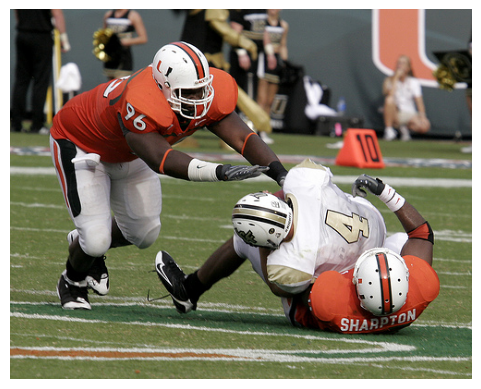

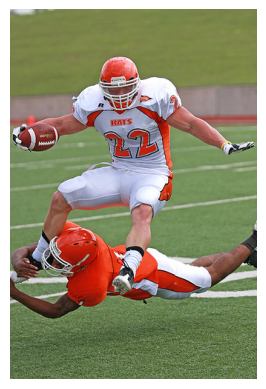

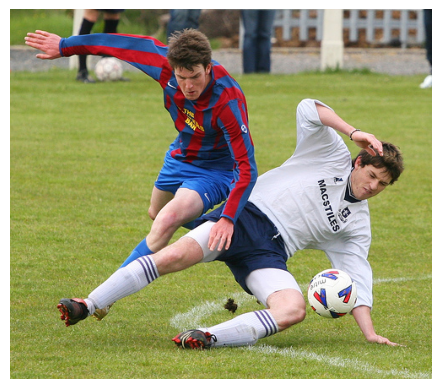

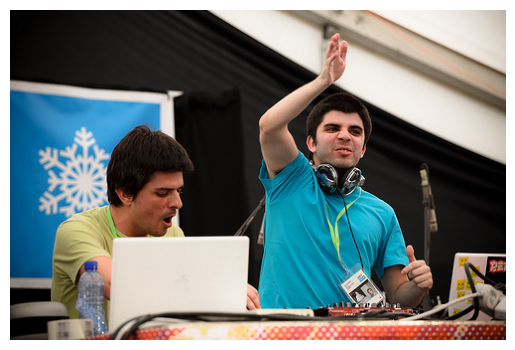

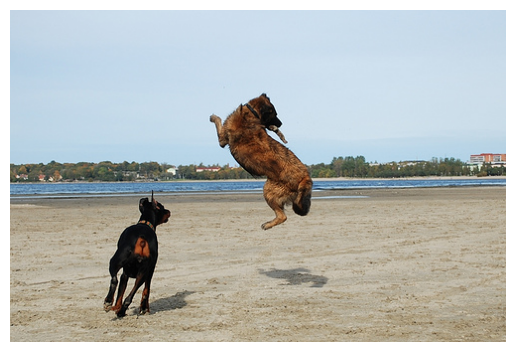

In [69]:
#Finally using everything we do some testing

query = "A group of people playing football"
image_directory = "C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flicker8k_Images\\"
top_images = retrieve_images(query, text_model, N=5)
display_images(top_images, image_directory)


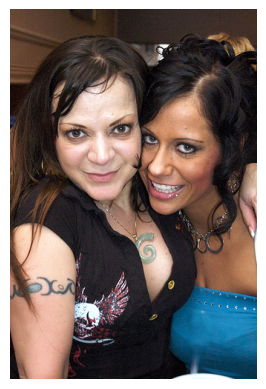

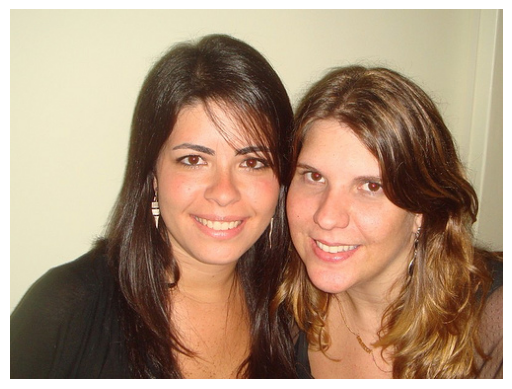

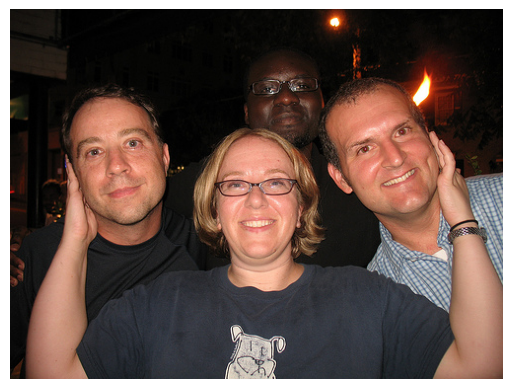

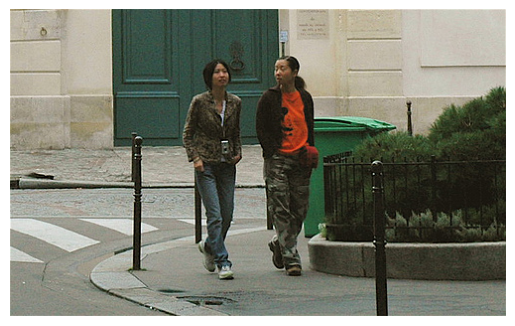

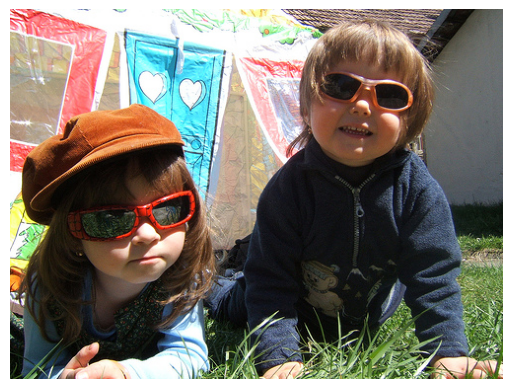

In [70]:
query = "A bunch of guys smiling"
image_directory = "C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flicker8k_Images\\"
top_images = retrieve_images(query, text_model, N=5)
display_images(top_images, image_directory)

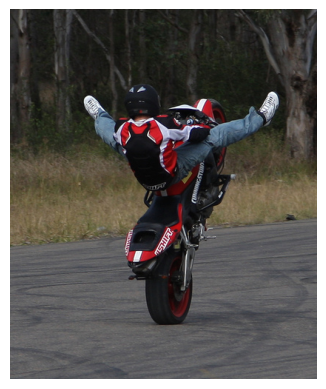

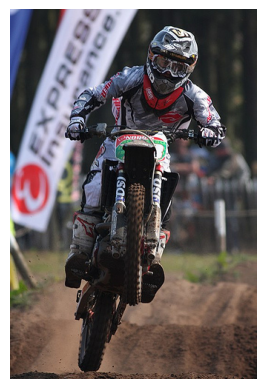

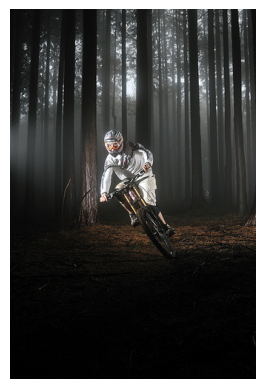

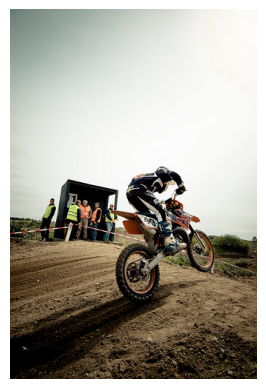

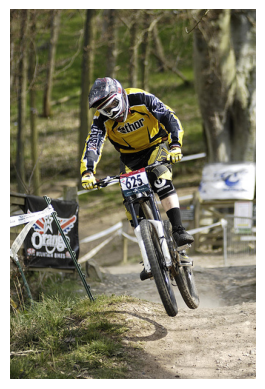

In [77]:
query = "Someone driving a vehicle"
image_directory = "C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flicker8k_Images\\"
top_images = retrieve_images(query, text_model, N=5)
display_images(top_images, image_directory)

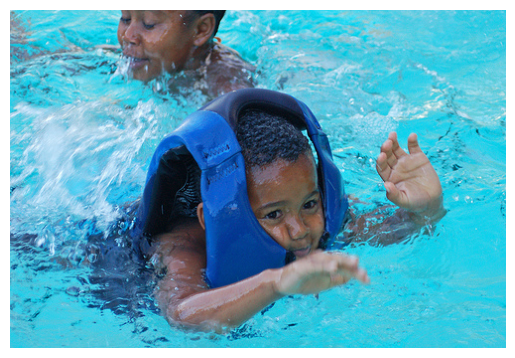

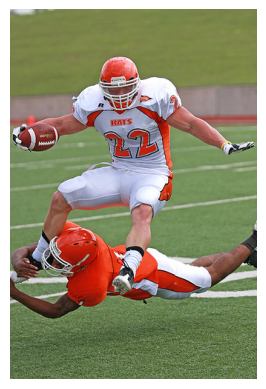

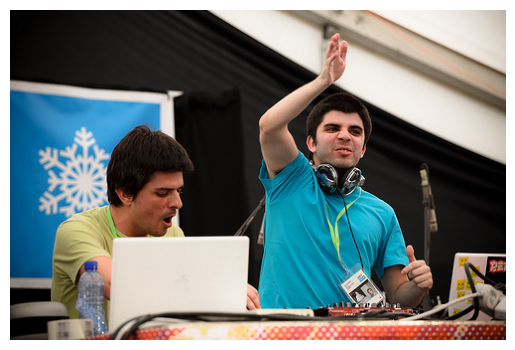

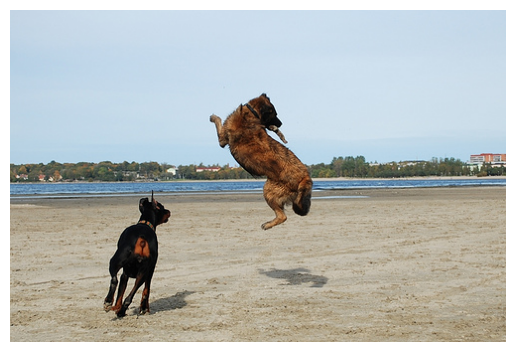

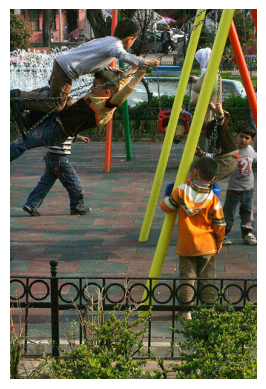

In [80]:
query = "Children in a playground"
image_directory = "C:\\Users\\rohit\\OneDrive\\Desktop\\Text based image retreival\\Data\\Flickr8K\\Flicker8k_Images\\"
top_images = retrieve_images(query, text_model, N=5)
display_images(top_images, image_directory)

# Final Conclusion

In [ ]:
#As we can see in a few cases above, the model is not VERY accurate. 
#This is because the dataset used for this contained about 32000 images and was only 1GB in size. 
#Ideally, we should be using much bigger datasets. 
#However, I used this one as my aim was to learn and practically experience this domain of AI.